### Experiment with trajectory sampling

In [70]:
import numpy as np
from math import gcd
from functools import reduce
import sympy as sp

x, y, z = sp.Symbol('x'), sp.Symbol('y'), sp.Symbol('z')

# ============================================================
# Utility functions
# ============================================================

def gcd_vec(u):
    return reduce(gcd, map(abs, u))

def norm(u):
    return np.linalg.norm(u)

def is_in_group(u, group, symbols):
    encoding = np.array([1 if symbol in group else 0 for symbol in symbols])
    mask = (u != 0)
    return not any(mask & (encoding == 0))

def format_group(A, group, symbols):
    encoding_mask = np.array([symbol in group for symbol in symbols])
    if np.all(encoding_mask):
        print('bad bad')
    return A[:, encoding_mask], encoding_mask

# ============================================================
# Integer Hit-and-Run Class
# ============================================================

class IntegerHitAndRunSampler:
    def __init__(self, A, b, R, u0, max_trials):
        """
        A u <= b   and   ||u|| <= R
        u has integer coordinates.
        u0 must be an initial feasible integer point.
        """
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.R = float(R)
        self.u = np.array(u0, dtype=float)
        self.dim = len(u0)
        self.max_trials = max_trials

    def _direction(self):
        """Sample a random integer direction d."""
        while True:
            d = np.random.normal(size=self.dim)
            d = np.round(d).astype(int)
            if np.any(d != 0):
                return d

    def _feasible_t_range(self, d):
        """Compute feasible integer t-range for u + t d."""
        A, b, u = self.A, self.b, self.u
        Ad = A @ d
        Au = A @ u

        t_min, t_max = -1e100, 1e100

        # Linear constraints A(u+td) ≤ b
        for i in range(len(Ad)):
            if abs(Ad[i]) < 1e-12:
                # constraint A_i d = 0 -> must satisfy Au ≤ b
                if Au[i] > b[i]:
                    return None
                continue
            # TODO: enforce the Ax < b and Ax!=b somehow better
            t_i = (b[i] - 1e-5 - Au[i]) / Ad[i]
            if Ad[i] > 0:
                t_max = min(t_max, t_i)
            else:
                t_min = max(t_min, t_i)

        # Ball constraint ||u+td|| ≤ R
        dd = np.dot(d, d)
        ud = np.dot(u, d)
        uu = np.dot(u, u)

        A_q = dd
        B_q = 2 * ud
        C_q = uu - self.R*self.R

        disc = B_q*B_q - 4*A_q*C_q
        if disc < 0:
            return None

        sqrt_disc = np.sqrt(disc)
        t1 = (-B_q - sqrt_disc) / (2*A_q)
        t2 = (-B_q + sqrt_disc) / (2*A_q)

        t_ball_min = min(t1, t2)
        t_ball_max = max(t1, t2)

        t_min = max(t_min, t_ball_min)
        t_max = min(t_max, t_ball_max)

        # Convert to integer range:
        t_int_min = int(np.ceil(t_min))
        t_int_max = int(np.floor(t_max))

        if t_int_min > t_int_max:
            return None

        return t_int_min, t_int_max

    def __iter__(self):
        return self

    def __next__(self):
        """Generate one new sample."""
        # TODO: add timeout
        tries = 0
        while True:
            d = self._direction()
            t_range = self._feasible_t_range(d)
            if t_range is None:
                continue
            t_min, t_max = t_range

            t = np.random.randint(t_min, t_max + 1)
            u_new = self.u + t * d

            # gcd requirement
            if gcd_vec(u_new.astype(int)) != 1:
                tries += 1
                if tries == self.max_trials:
                    return None
                continue

            self.u = u_new
            return self.u.astype(int)


In [71]:
import numpy as np
from scipy.optimize import linprog

def is_cone_empty(A):
    # Solve A x <= 0
    m, d = A.shape
    c = np.zeros(d)
    bounds = [(None, None)] * d

    res = linprog(c, A_ub=A, b_ub=np.zeros(m), bounds=bounds, method="highs")
    return not res.success


def cone_has_nonzero(A):
    m, d = A.shape
    b = np.zeros(m)
    bounds = [(None, None)] * d

    for i in range(d):
        c = np.zeros(d)
        c[i] = -1  # maximize u_i ⇔ minimize -u_i
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")
        if res.success and res.x[i] > 1e-9:
            return True

        c[i] = +1  # minimize u_i
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")
        if res.success and res.x[i] < -1e-9:
            return True

    return False


def integer_feasible(A, R):
    """Check if the bounded integer system Au<=0, |u|<=R has ANY solution."""
    m, d = A.shape
    b = np.zeros(m)
    bounds = [(-R, R)] * d

    # objective irrelevant
    c = np.zeros(d)

    # Try to find a feasible point
    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")
    if not res.success:
        return False
    return True


In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_samples(samples, title="3D Sample Distribution"):
    samples = np.array(samples)
    fig = plt.figure(figsize=(12, 6))

    # 3D scatter
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.scatter([0]+ samples[:,0], [0]+samples[:,1], [0]+samples[:,2], s=10, alpha=0.6)
    # ax.scatter([0], [0], [0], color='red')
    ax.set_title(title)
    ax.set_xlabel("u1")
    ax.set_ylabel("u2")
    ax.set_zlabel("u3")

    # Histograms
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.hist(samples[:,0], bins=20, alpha=0.5, label="u1")
    ax2.hist(samples[:,1], bins=20, alpha=0.5, label="u2")
    ax2.hist(samples[:,2], bins=20, alpha=0.5, label="u3")
    ax2.legend()
    ax2.set_title("Coordinate Distributions")

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_3d_samples_with_hyperplanes(samples, A, b, R=20, alpha=0.15):
    """
    Plot 3D points along with the hyperplanes A_i x = b_i.
    R defines the clipping region for the plane polygons.
    """
    samples = np.array(samples)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # -----------------------------------------------------
    # Plot sample points
    # -----------------------------------------------------
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2],
               s=10, alpha=0.7, color="blue")

    # -----------------------------------------------------
    # Plot each hyperplane
    # -----------------------------------------------------
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)

    # Cube corners to clip planes
    cube_pts = np.array([
        [x, y, z]
        for x in [-R, R]
        for y in [-R, R]
        for z in [-R, R]
    ])

    from itertools import combinations

    for i in range(len(A)):
        Ai = A[i]
        bi = b[i]

        # Find intersection points of plane with edges of cube
        poly_points = []
        for p, q in combinations(cube_pts, 2):
            p = np.array(p, dtype=float)
            q = np.array(q, dtype=float)
            d = q - p

            denom = Ai @ d
            if abs(denom) < 1e-12:
                continue

            t = (bi - Ai @ p) / denom
            if 0 <= t <= 1:
                inter = p + t * d
                poly_points.append(inter)

        if len(poly_points) < 3:
            continue

        # Make a convex hull of intersection polygon
        poly_points = np.array(poly_points)

        # Project to 2D plane coords for ordering
        # Find 2 largest orthonormal basis vectors for the plane
        n = Ai / np.linalg.norm(Ai)
        # Choose an arbitrary vector not parallel to n
        tmp = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(tmp, n)) > 0.9:
            tmp = np.array([0.0, 1.0, 0.0])

        v1 = tmp - np.dot(tmp, n) * n
        v1 /= np.linalg.norm(v1)
        v2 = np.cross(n, v1)

        # Coordinates in plane basis
        coords = np.column_stack([poly_points @ v1, poly_points @ v2])

        # Order polygon vertices
        center = coords.mean(axis=0)
        angles = np.arctan2(coords[:, 1] - center[1], coords[:, 0] - center[0])
        order = np.argsort(angles)
        poly_points = poly_points[order]

        # Add plane polygon
        poly = Poly3DCollection([poly_points], alpha=alpha)
        poly.set_facecolor(np.random.rand(3))
        ax.add_collection3d(poly)

    # -----------------------------------------------------
    # Plot settings
    # -----------------------------------------------------
    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)
    ax.set_zlim(-R, R)
    ax.set_xlabel("u1")
    ax.set_ylabel("u2")
    ax.set_zlabel("u3")
    ax.set_title("3D Sampling With Hyperplanes")

    plt.tight_layout()
    plt.show()


[[1]
 [0]
 [0]]
[0 0 0]
[0]
Only trivial point 0 is feasible → no gcd=1 integer solutions


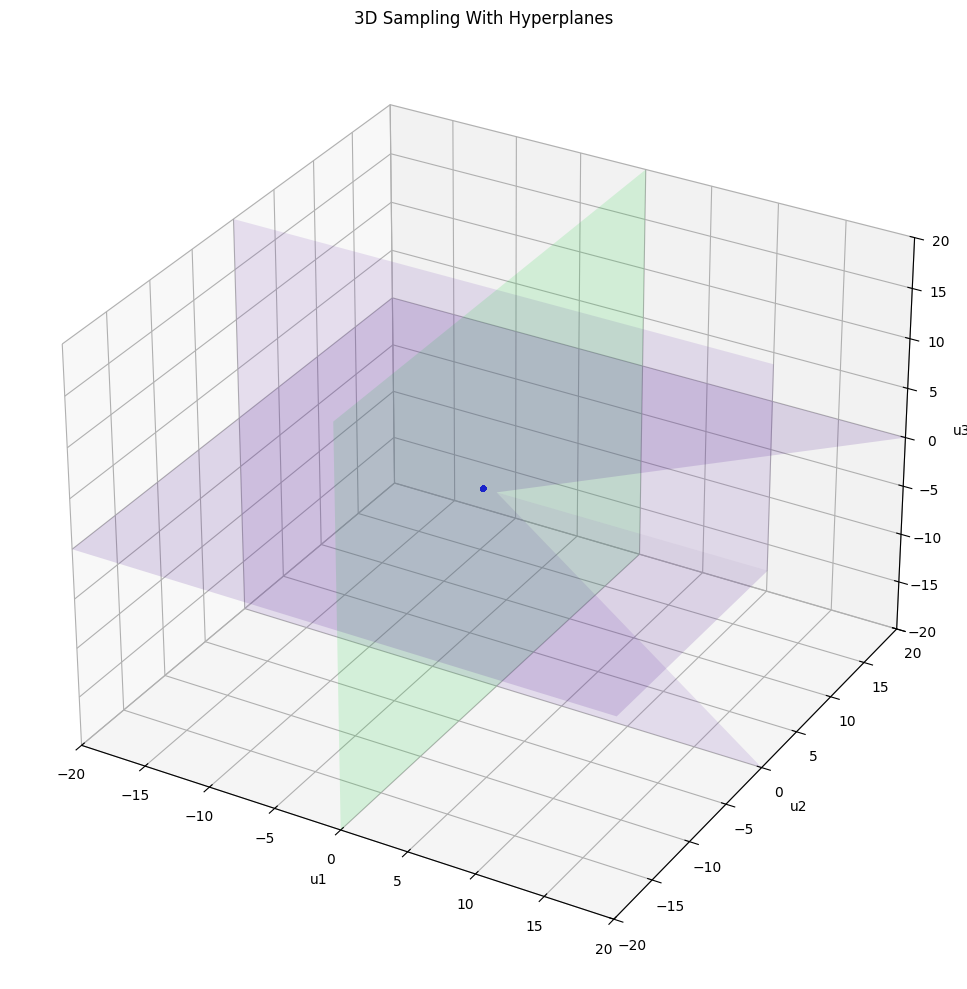

In [86]:
# =============================================
# 3D DEMO
# =============================================

A = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
# (
#     np.vstack([
#     # np.ones(dim),
#     np.eye(dim)
# ]))

symbols = [x, y, z]
mask = [x]
A_orig = A
A, mask_encode = format_group(A, mask, symbols)
dim = A.shape[1]

b = np.zeros(A.shape[0], dtype=int)

u0 = np.zeros(dim, dtype=int)
R = 20.0
print(A)
print(b)
print(u0)

sampler = IntegerHitAndRunSampler(A, b, R, u0, 1e6)

def reconstruct(x_reduced, mask):
    x = np.zeros(len(mask), dtype=x_reduced.dtype)
    x[mask] = x_reduced
    return x

if is_cone_empty(A):
    print("No real solutions → no integer solutions")
elif not cone_has_nonzero(A):
    print("Only trivial point 0 is feasible → no gcd=1 integer solutions")
elif not integer_feasible(A, R):
    print("Cone exists but contains no integer point up to radius R")
else:
    print("Integer feasible → IHR can start safely!")



# sample 5000 points
samples = [next(sampler) for _ in range(5000)]
samples = [reconstruct(s, mask_encode) for s in samples]
for sample in samples:
    if gcd_vec(sample) != 1:
        print(f'bad sample: {sample}')

# plot_3d_samples(samples, "IHR 3D integer sampling")
plot_3d_samples_with_hyperplanes(samples, A_orig, np.zeros(A_orig.shape[0], dtype=int), R=20)

# TODO: maybe in order to ingore null trajectories check if all simple trajectories lie on HPs then no trajectory possible
#       Also, add timeout.